### ME21BTECH11001 Abhishek Ghosh





Required Normal Force (N) using Newton-Raphson: 36.7140 N


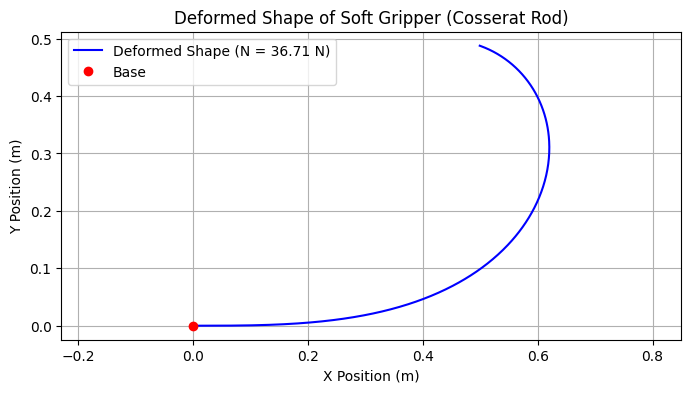

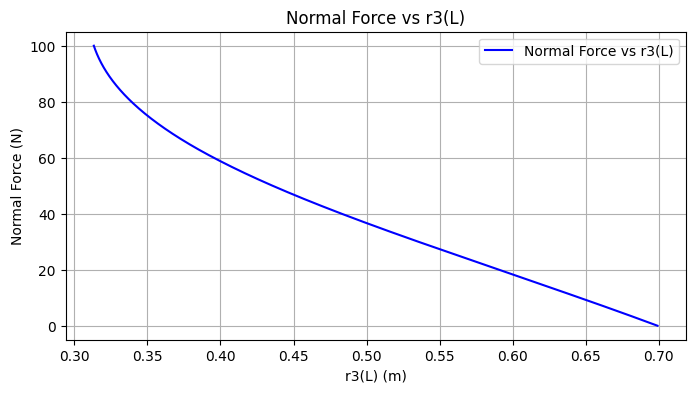

Maximum Frictional Resistance: 18.3570 N


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters (adjust as per system specifications)
EI = 5.0  # Flexural rigidity (Nm²)
F = 20.0  # Applied force (N)
L = 1.0   # Length of the gripper (m)
b = 1.0   # Length of the workpiece (m)
mu = 0.5  # Friction coefficient

# Define the governing differential equation for the gripper
def cosserat_ode(x, y, N):
    theta, dtheta_dx = y
    d2theta_dx2 = -(F * np.cos(theta) - N * np.sin(theta)) / EI
    return [dtheta_dx, d2theta_dx2]

# Initial conditions
initial_theta = 0.0  # Initial angle (radians)
initial_dtheta_dx = 0.0  # Initial slope

# Solve the differential equation for a given normal force N
def solve_deformation(N):
    solution = solve_ivp(
        cosserat_ode, [0, L], [initial_theta, initial_dtheta_dx], args=(N,),
        t_eval=np.linspace(0, L, 500)
    )
    return solution

# Objective function to match target r3(L) to b/2
def objective_function(N):
    solution = solve_deformation(N)
    theta_vals = solution.y[0]
    # Compute r3(L) using numerical integration
    r3_L = np.trapz(np.cos(theta_vals), solution.t)
    return r3_L - b / 2

# Numerical derivative of the objective function for Newton-Raphson method
def derivative_objective_function(N, h=1e-5):
    """Compute the numerical derivative of the objective function."""
    return (objective_function(N + h) - objective_function(N)) / h

# Newton-Raphson method for finding N
def newton_raphson_method(initial_guess, tolerance=1e-6, max_iterations=100):
    N = initial_guess
    for i in range(max_iterations):
        f_value = objective_function(N)
        f_derivative = derivative_objective_function(N)

        # Update N using the Newton-Raphson formula
        N_new = N - f_value / f_derivative

        # Check for convergence
        if abs(N_new - N) < tolerance:
            return N_new

        N = N_new

    raise ValueError("Newton-Raphson method did not converge")

# Use Newton-Raphson to find the required normal force N
try:
    N_required_newton = newton_raphson_method(initial_guess=10.0)
    print(f"Required Normal Force (N) using Newton-Raphson: {N_required_newton:.4f} N")
except ValueError as e:
    print(f"Error: {e}")
    N_required_newton = None

# Solve the deformation with the required N
if N_required_newton is not None:
    solution = solve_deformation(N_required_newton)

    # Extract results for plotting
    x_vals = solution.t
    theta_vals = solution.y[0]

    # Compute the deformed shape coordinates
    x_coords = np.cumsum(np.cos(theta_vals)) * (L / len(x_vals))
    y_coords = -np.cumsum(np.sin(theta_vals)) * (L / len(x_vals))  # Flip for upside-down view

    # Plot the deformed shape
    plt.figure(figsize=(8, 4))
    plt.plot(x_coords, y_coords, 'b-', label=f"Deformed Shape (N = {N_required_newton:.2f} N)")
    plt.plot(0, 0, 'ro', label="Base")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.title("Deformed Shape of Soft Gripper (Cosserat Rod)")
    plt.legend()
    plt.axis("equal")
    plt.grid(True)
    plt.show()

    # Plot normal force variation
    normal_forces = np.linspace(0.1, 100, 500)
    r3_values = [objective_function(N) + b / 2 for N in normal_forces]

    plt.figure(figsize=(8, 4))
    plt.plot( r3_values,normal_forces,'b-', label="Normal Force vs r3(L)")

    plt.ylabel("Normal Force (N)")
    plt.xlabel("r3(L) (m)")
    plt.title("Normal Force vs r3(L)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and display the maximum frictional resistance
    max_friction_resistance = mu * N_required_newton
    print(f"Maximum Frictional Resistance: {max_friction_resistance:.4f} N")
else:
    print("No deformation solution available due to root-finding failure.")